In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,recall_score

import torch
import torch.nn as nn
import pickle

This is a Bank Churn Prediction problem. I obtained the dataset from kaggle here:<br> https://www.kaggle.com/datasets/barelydedicated/bank-customer-churn-modeling <br>
It is a binary classification problem with imbalanced classes. The positive class is the class of interest, ie, prediction that the customer is leaving. One does not want to miss any positive prediction. Hence, the metric of interest is recall.

In [2]:
df = pd.read_csv("Churn_Modelling.csv")

In [5]:
df['Exited'].value_counts()/df.shape[0]

0    0.7963
1    0.2037
Name: Exited, dtype: float64

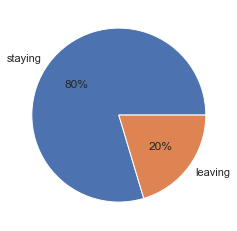

In [74]:
plt.pie(df['Exited'].value_counts(),labels=['staying','leaving'],autopct='%1.0f%%')
plt.show()

The dataset is not too terribly imbalanced.

In [6]:
df.shape

(10000, 14)

In [7]:
df

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [8]:
df.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)

In [75]:
df

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


### Exploratory Data Analysis

In [12]:
num_cols = df.select_dtypes(include=np.number).columns.tolist()
cat_cols = df.select_dtypes(include='O').columns.tolist()
num_cols.remove('Exited')

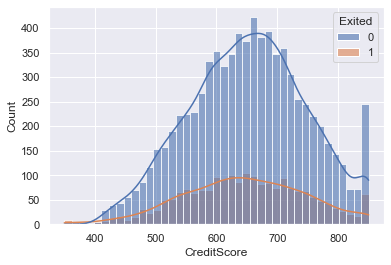

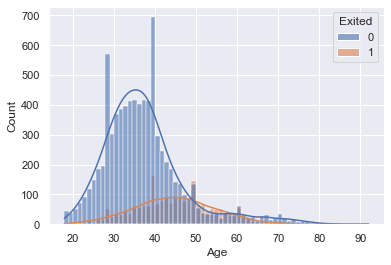

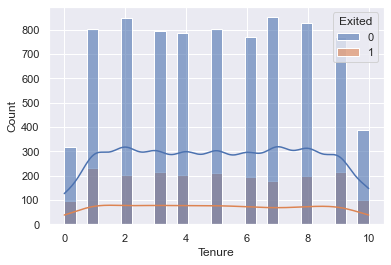

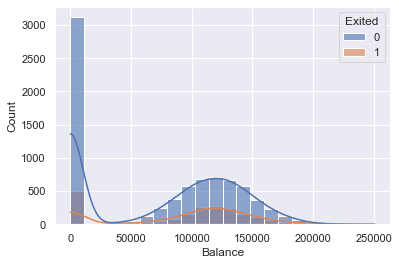

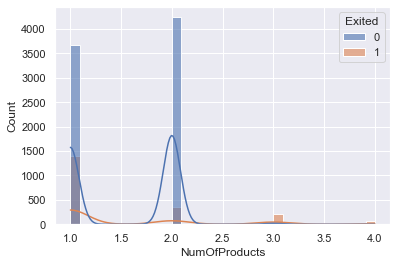

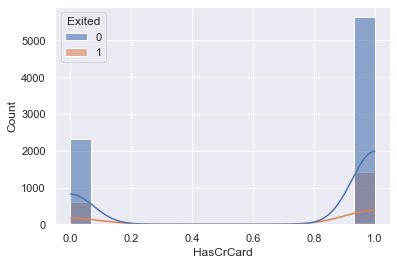

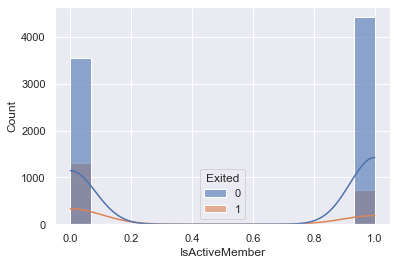

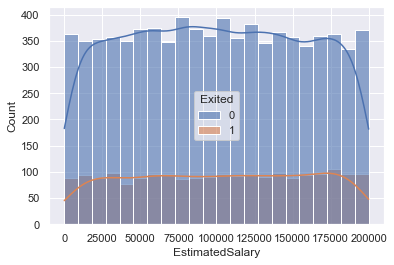

In [76]:
for i in num_cols:
    sns.histplot(data=df,x=i,hue='Exited',alpha=0.6,kde='True')
    plt.xlabel(i)
    plt.show()

The histograms of the numerical columns don't give any obvious insights. I see some difference in distributions in the Age feature.

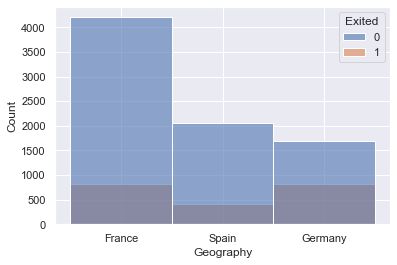

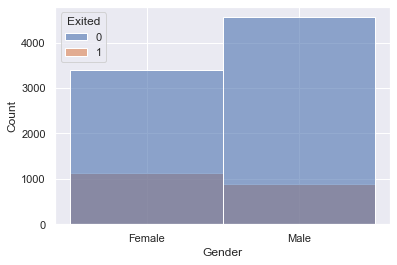

In [15]:
for i in cat_cols:
    sns.histplot(data=df,x=i,alpha=0.6,hue='Exited')
    plt.xlabel(i)
    plt.show()

Here, I see a difference in distributions of classes in the different categories of both the categorical features.<br>
I will use One Hot Encoder for Geography (and drop the first column, to avoid multi-collinearity).

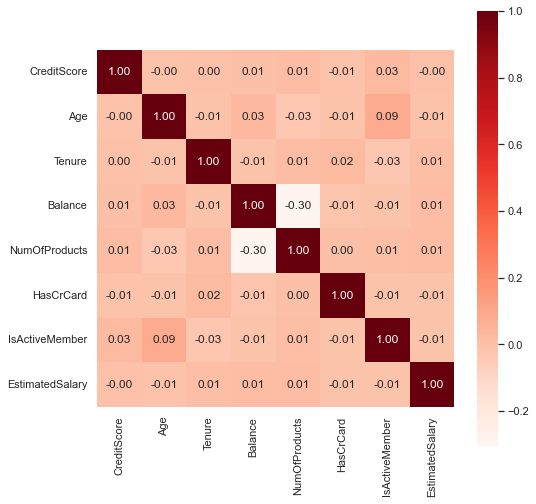

In [18]:
fig,ax = plt.subplots(figsize=(8,8))
sns.heatmap(df[num_cols].corr(),square=True,annot=True,cbar=True,cmap='Reds',fmt='0.2f')
plt.show()

The correlation matrix looks clean enough. Balance and NumOfProducts are inversely correlated.

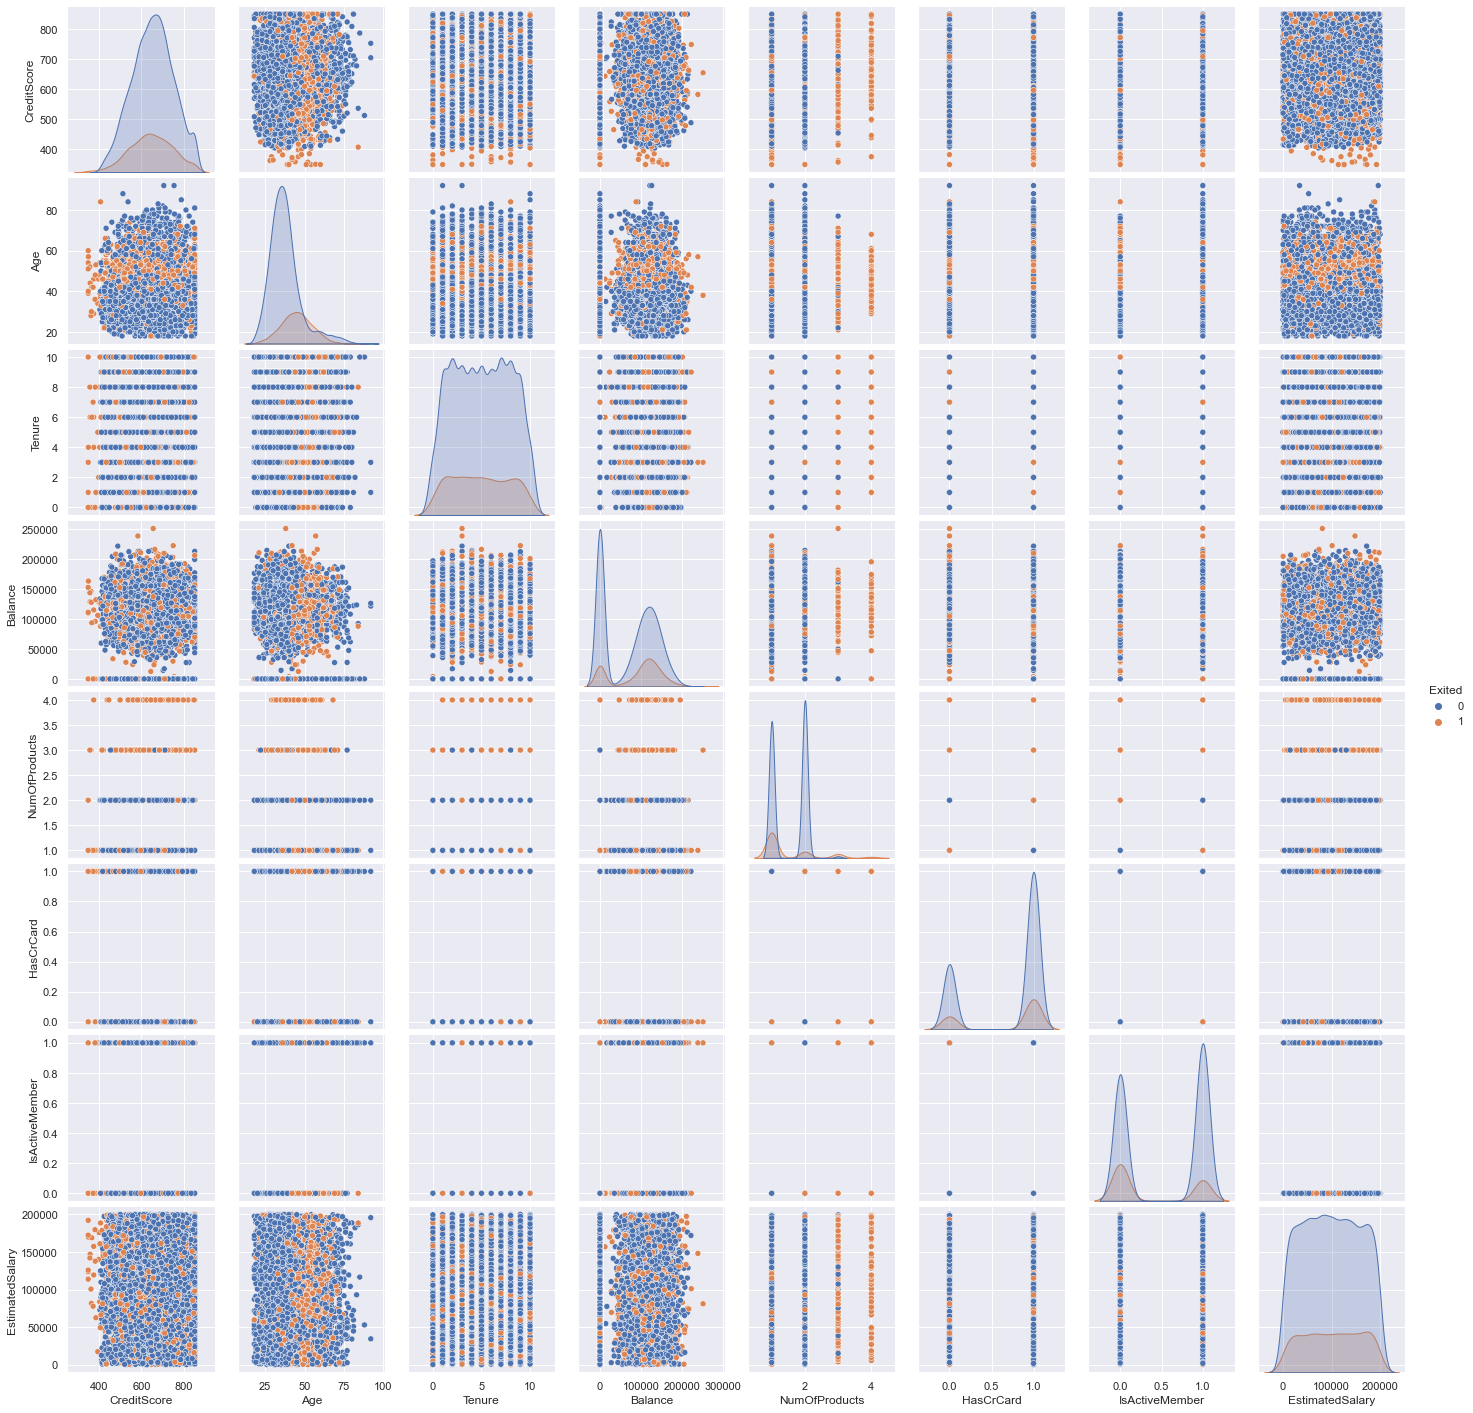

In [19]:
sns.pairplot(df,hue='Exited')
plt.show()

Now here, we see some clear class separation in a number of the scatter plots. The feature, NumOfProducts shows class separation across almost all features.

### Preparing Data for Model Fitting

In [45]:
trainX,testX,trainY,y_test = train_test_split(df.drop('Exited',axis=1),df['Exited'],test_size=0.2,random_state=2)

col_tran = ColumnTransformer([('country',OneHotEncoder(drop='first',sparse=False),['Geography']),
                               ('gender',OrdinalEncoder(),['Gender']),
                               ('scaler',StandardScaler(),num_cols)],remainder='passthrough')
col_tran.fit(trainX)

X_train, X_valid, y_train, y_valid = train_test_split(trainX,trainY,test_size=0.2,random_state=2)

X_train, X_valid, X_test, y_test = col_tran.transform(X_train), col_tran.transform(X_valid), col_tran.transform(testX), testY

In [51]:
def to_tensor(X,y):
    Xt = torch.from_numpy(X).to(torch.float)
    yt = torch.from_numpy(y.values).reshape(-1,1).to(torch.float)
    return Xt, yt

Xt_train, yt_train = to_tensor(X_train, y_train)
Xt_valid, yt_valid = to_tensor(X_valid, y_valid)
Xt_test, yt_test = to_tensor(X_test, y_test)

### Neural Network Model

I will train a neural network with one hidden layer having input layer size 11, hidden layer size 50, and output layer size 10.

In [56]:
class NN(nn.Module):
    def __init__(self):
        super(NN,self).__init__()
        self.layers = nn.Sequential(nn.Linear(11,50), nn.ReLU(),
                                    nn.Linear(50,10), nn.ReLU(),
                                    nn.Linear(10,1), nn.Sigmoid())
        
    def forward(self,x):
        return self.layers(x)
    
def train(model, n_epoch, patience, lr, plotloss, plotmetrics, X_train, X_valid, y_train, y_valid):
    
    model.train()
    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    printstep = int(n_epoch/10)
    
    last_loss = 100.
    trigger = 0
    
    if(plotloss):
        epoch_loss_train = list()
        epoch_loss_valid = list()
    
    if (plotmetrics):
        epoch_score_train = list()
        epoch_score_valid = list()
        epoch_recall_train = list()
        epoch_recall_valid = list()
    
    for epoch in range(1,n_epoch+1):
        
        optimizer.zero_grad()
        y_pred_train = model(X_train)
        loss = criterion(y_pred_train,y_train)
        loss.backward()
        optimizer.step()
        
        if(epoch%printstep == 0):
            print("Epoch {}, Loss {}".format(epoch,loss.item()))
        
        
        if (plotmetrics):
            epoch_score_train.append(model_accuracy(X_train, y_train))
            epoch_score_valid.append(model_accuracy(X_valid, y_valid))
            epoch_recall_train.append(model_recall(X_train, y_train))
            epoch_recall_valid.append(model_recall(X_valid, y_valid))
        
        #early stopping
        y_pred_valid = model(X_valid)
        loss_valid = criterion(y_pred_valid,y_valid)
        new_loss = loss_valid.item()
        if (plotloss):
            epoch_loss_train.append(loss.item())
            epoch_loss_valid.append(new_loss)
        
        if(new_loss > last_loss):
            trigger += 1
            if(trigger > patience):
                print("Early Stopping at Epoch {}".format(epoch))
                break
        else:
            trigger = 0
        last_loss = new_loss
        
    plt.plot(epoch_loss_train)
    plt.plot(epoch_loss_valid)
    plt.legend(['Training Loss','Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    if(plotmetrics):
        fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,5))
        ax1.plot(epoch_score_train)
        ax1.plot(epoch_score_valid)
        ax1.set_ylim(0,1)
        ax1.set_xlabel('Epoch')
        ax1.set_title('Accuracy Score')
        
        ax2.plot(epoch_recall_train)
        ax2.plot(epoch_recall_valid)
        ax2.set_ylim(0,1)
        ax2.set_xlabel('Epoch')
        ax2.set_title('Recall Score')
        
        fig.legend(['Training','Validation'])
        plt.show()
    return model

In [57]:
def model_prediction(X):
    y = model(X).detach().numpy()
    y[y>=0.5] = 1
    y[y<0.5] = 0
    return y

def model_accuracy(X,y):
    y_pred = model_prediction(X)
    return accuracy_score(y,y_pred)

def model_recall(X,y):
    y_pred = model_prediction(X)
    return recall_score(y,y_pred)    

def model_scores(X,y):
    print("Accuracy: %s"%model_accuracy(X,y))
    print("Recall:   %s"%model_recall(X,y))

Epoch 100, Loss 0.4998987913131714
Epoch 200, Loss 0.3568481504917145
Epoch 300, Loss 0.32849881052970886
Epoch 400, Loss 0.3177676200866699
Early Stopping at Epoch 414


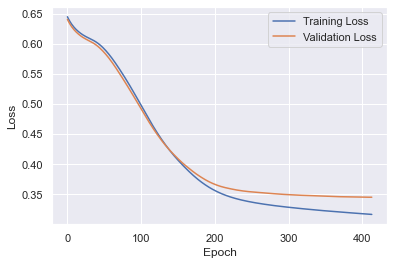

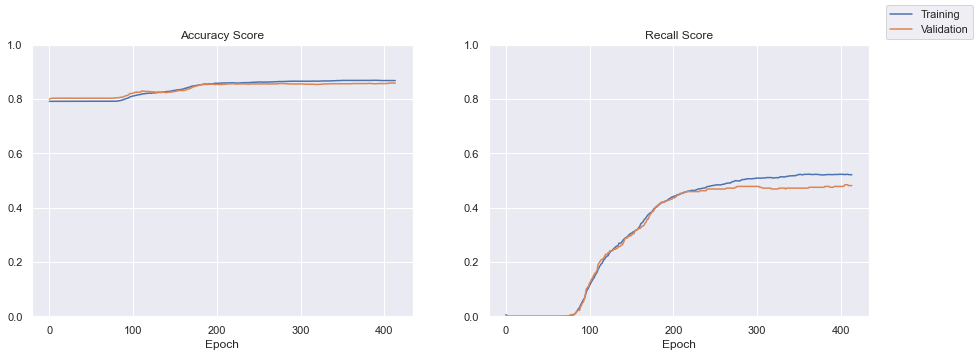

In [58]:
n_epoch = 1000
patience = 2
lr = 0.001
plotloss = True
plotmetrics = True

model = NN()
model = train(model, n_epoch, patience, lr, plotloss, plotmetrics, Xt_train, Xt_valid, yt_train, yt_valid)

The model isn't great, wrt recall score, but it isn't the worst either. Recall score is 42.6% for the test set. I will try to improve the model performance by training up-sampling the minority class and training the model again.

In [59]:
print("Test Set")
model_scores(Xt_test, yt_test)
print("Training Set")
model_scores(Xt_train, yt_train)
print("Validation Set")
model_scores(Xt_valid, yt_valid)

Test Set
Accuracy: 0.8535
Recall:   0.4255874673629243
Training Set
Accuracy: 0.86734375
Recall:   0.5209267563527653
Validation Set
Accuracy: 0.858125
Recall:   0.4810126582278481


### Over-sampling the Minority Class

In [60]:
traindf = pd.concat([trainX,pd.DataFrame(trainY)],axis=1)

n0, n1 = traindf['Exited'].value_counts() #number of instances in each class

class0 = traindf[traindf['Exited']==0]
class1 = traindf[traindf['Exited']==1]

I will boost proportion of class 1 from 20% to ~40%. Taking $3n_1$ samples gives ~40% of total.

In [65]:
print("Before Resampling")
print("Fraction of Class 1: {}".format(n1/(n0+n1))) 

class1over = class1.sample(3*n1,replace=True) 
overdf = pd.concat([class0,class1over],axis=0).sample(frac=1)

print("After Resampling")
print("Fraction of Class 1: {}".format(overdf['Exited'].value_counts()[1]/overdf['Exited'].value_counts().sum()))

Before Resampling
Fraction of Class 1: 0.20675
After Resampling
Fraction of Class 1: 0.4388043862752034


In [68]:
#making new training and validation sets
X_train, X_valid, y_train, y_valid = train_test_split(overdf.drop('Exited',axis=1),overdf['Exited'],test_size=0.2,random_state=2)
X_train = col_tran.transform(X_train)
X_valid = col_tran.transform(X_valid)

Xt_train, yt_train = to_tensor(X_train, y_train)
Xt_valid, yt_valid = to_tensor(X_valid, y_valid)

Epoch 100, Loss 0.5341017246246338
Epoch 200, Loss 0.4504138231277466
Epoch 300, Loss 0.4251481592655182
Epoch 400, Loss 0.4083944857120514
Epoch 500, Loss 0.3894849419593811
Early Stopping at Epoch 584


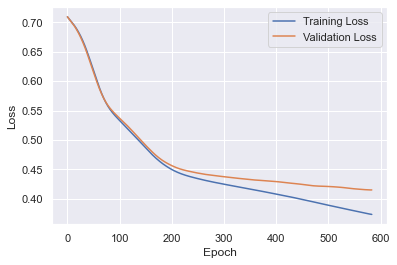

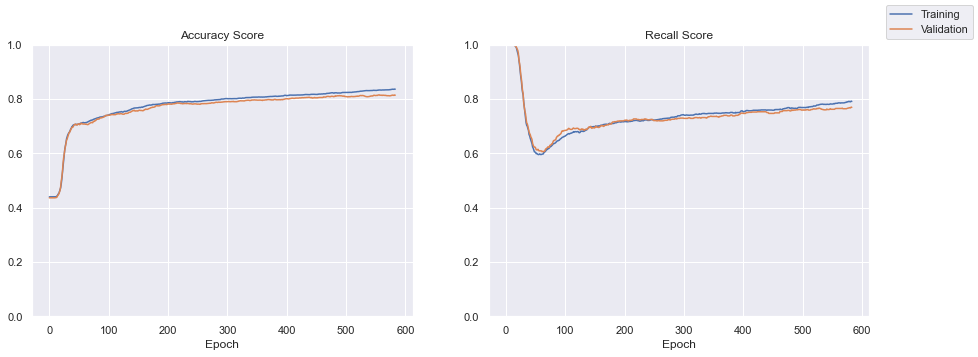

In [72]:
#Re-training
n_epoch = 1000
patience = 2
lr = 0.001
plotloss = True
plotmetrics = True

model = NN()
model = train(model, n_epoch, patience, lr, plotloss, plotmetrics, Xt_train, Xt_valid, yt_train, yt_valid)

Earlier, training set recall was ~50%, and test set recall was 42%. <br>
Now, training set recall is ~80%, and test set recall is ~60%.

In [73]:
print("Test Set")
model_scores(Xt_test, yt_test)
print("Training Set")
model_scores(Xt_train, yt_train)
print("Validation Set")
model_scores(Xt_valid, yt_valid)

Test Set
Accuracy: 0.8115
Recall:   0.6109660574412533
Training Set
Accuracy: 0.8356179526862701
Recall:   0.7904929577464789
Validation Set
Accuracy: 0.8134394341290893
Recall:   0.768762677484787


In [78]:
pickle.dump(model,open('nn_model.pkl','wb'))

In [79]:
torch.save(model.state_dict(), 'model_state.pt')